# E-Commerce Customer Churn Analysis: Stratified Sampling Strategy

## Business Problem
**Objective:** Predict customer churn and survival patterns in e-commerce to identify at-risk customers and optimize retention strategies.

## Dataset Overview
- **Source:** REES46 E-commerce Events Dataset (2019-Oct.csv & 2019-Nov.csv)
- **Total Records:** ~110 million events (42.4M Oct + 67.5M Nov)
- **Features:** event_time, event_type, product_id, category_id, category_code, brand, price, user_id, user_session
- **Event Types:** view, cart, purchase

## Sampling Strategy Overview
This notebook implements a **Smart Stratified User-Level Sampling** approach that:
1. ✅ Preserves complete customer journeys (all events for sampled users)
2. ✅ Over-represents high-value buyers (critical for churn analysis)
3. ✅ Maintains temporal sequence and session integrity
4. ✅ Reduces data volume by ~90% while retaining 95%+ of purchase events
5. ✅ Enables survival analysis with proper censoring and time-to-event data

## Why This Approach?
- **Random Sampling Issues:** Would break customer journeys and lose rare buyers
- **Event-Level Sampling Issues:** Would create incomplete user histories
- **Our Solution:** User-level stratified sampling ensures representative, analysis-ready data

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully
Analysis Date: 2025-12-02 16:57:56
Pandas version: 2.2.3
NumPy version: 2.2.4


## Step 1: Load Data in Chunks (Memory-Efficient)

Given the large dataset size (~110M rows), we'll:
1. Load data in chunks to avoid memory issues
2. Immediately aggregate to user level
3. Keep only essential columns for sampling

In [2]:
# Configuration
CHUNK_SIZE = 1_000_000  # Process 1M rows at a time
DATA_FOLDER = 'Data/'

print(f"\n{'='*60}")
print(f"DATA LOADING CONFIGURATION")
print(f"{'='*60}")
print(f"Chunk size: {CHUNK_SIZE:,} rows")
print(f"Data folder: {DATA_FOLDER}")
print(f"\nThis will take several minutes due to file size...")
print(f"Processing in chunks to avoid memory issues.")


DATA LOADING CONFIGURATION
Chunk size: 1,000,000 rows
Data folder: Data/

This will take several minutes due to file size...
Processing in chunks to avoid memory issues.


In [3]:
# Function to process chunks and build user summary
def process_file_in_chunks(filepath, chunk_size=1_000_000):
    """
    Process large CSV file in chunks and aggregate to user level.
    Returns user-level summary statistics.
    """
    print(f"\nProcessing: {filepath}")
    
    user_metrics = {}
    chunk_num = 0
    
    for chunk in pd.read_csv(filepath, chunksize=chunk_size):
        chunk_num += 1
        print(f"  Chunk {chunk_num}: {len(chunk):,} rows", end='\r')
        
        # Convert timestamp
        chunk['event_time'] = pd.to_datetime(chunk['event_time'], utc=True)
        
        # Process each user in chunk
        for user_id, user_data in chunk.groupby('user_id'):
            if user_id not in user_metrics:
                user_metrics[user_id] = {
                    'total_events': 0,
                    'n_sessions': set(),
                    'n_views': 0,
                    'n_carts': 0,
                    'n_purchases': 0,
                    'total_spent': 0.0,
                    'first_event': None,
                    'last_event': None,
                    'unique_products': set(),
                    'unique_brands': set(),
                    'unique_categories': set()
                }
            
            metrics = user_metrics[user_id]
            
            # Update metrics
            metrics['total_events'] += len(user_data)
            metrics['n_sessions'].update(user_data['user_session'].unique())
            metrics['n_views'] += (user_data['event_type'] == 'view').sum()
            metrics['n_carts'] += (user_data['event_type'] == 'cart').sum()
            metrics['n_purchases'] += (user_data['event_type'] == 'purchase').sum()
            
            # Revenue
            purchases = user_data[user_data['event_type'] == 'purchase']
            metrics['total_spent'] += purchases['price'].sum()
            
            # Temporal
            first = user_data['event_time'].min()
            last = user_data['event_time'].max()
            metrics['first_event'] = first if metrics['first_event'] is None else min(metrics['first_event'], first)
            metrics['last_event'] = last if metrics['last_event'] is None else max(metrics['last_event'], last)
            
            # Diversity
            metrics['unique_products'].update(user_data['product_id'].unique())
            metrics['unique_brands'].update(user_data['brand'].dropna().unique())
            metrics['unique_categories'].update(user_data['category_code'].dropna().unique())
    
    print(f"\n  ✅ Processed {chunk_num} chunks")
    return user_metrics

# Process both files
print(f"\n{'='*60}")
print(f"STEP 1: LOADING & AGGREGATING DATA")
print(f"{'='*60}")

user_metrics_oct = process_file_in_chunks(DATA_FOLDER + '2019-Oct.csv', CHUNK_SIZE)
user_metrics_nov = process_file_in_chunks(DATA_FOLDER + '2019-Nov.csv', CHUNK_SIZE)

print(f"\n{'='*60}")
print(f"Merging October and November data...")


STEP 1: LOADING & AGGREGATING DATA

Processing: Data/2019-Oct.csv
  Chunk 43: 448,764 rowsws
  ✅ Processed 43 chunks

Processing: Data/2019-Nov.csv
  Chunk 68: 501,979 rowsws
  ✅ Processed 68 chunks

Merging October and November data...


In [5]:
# Merge metrics from both months
all_users = set(user_metrics_oct.keys()) | set(user_metrics_nov.keys())
print(f"Total unique users across both months: {len(all_users):,}")

combined_metrics = {}
for user_id in all_users:
    oct_data = user_metrics_oct.get(user_id, {})
    nov_data = user_metrics_nov.get(user_id, {})
    
    combined_metrics[user_id] = {
        'user_id': user_id,
        'total_events': oct_data.get('total_events', 0) + nov_data.get('total_events', 0),
        'n_sessions': len(oct_data.get('n_sessions', set()) | nov_data.get('n_sessions', set())),
        'n_views': oct_data.get('n_views', 0) + nov_data.get('n_views', 0),
        'n_carts': oct_data.get('n_carts', 0) + nov_data.get('n_carts', 0),
        'n_purchases': oct_data.get('n_purchases', 0) + nov_data.get('n_purchases', 0),
        'total_spent': oct_data.get('total_spent', 0) + nov_data.get('total_spent', 0),
        'unique_products_viewed': len(oct_data.get('unique_products', set()) | nov_data.get('unique_products', set())),
        'unique_brands': len(oct_data.get('unique_brands', set()) | nov_data.get('unique_brands', set())),
        'unique_categories': len(oct_data.get('unique_categories', set()) | nov_data.get('unique_categories', set())),
    }
    
    # Temporal metrics
    first_dates = [d for d in [oct_data.get('first_event'), nov_data.get('first_event')] if d is not None]
    last_dates = [d for d in [oct_data.get('last_event'), nov_data.get('last_event')] if d is not None]
    
    if first_dates and last_dates:
        first = min(first_dates)
        last = max(last_dates)
        combined_metrics[user_id]['first_event'] = first
        combined_metrics[user_id]['last_event'] = last
        combined_metrics[user_id]['tenure_days'] = (last - first).days + 1
    else:
        combined_metrics[user_id]['tenure_days'] = 1

# Convert to DataFrame
user_summary = pd.DataFrame(list(combined_metrics.values()))

# Calculate derived metrics
user_summary['avg_events_per_session'] = user_summary['total_events'] / (user_summary['n_sessions'] + 1)
user_summary['conversion_rate'] = user_summary['n_purchases'] / (user_summary['n_views'] + 1)
user_summary['cart_to_purchase_rate'] = user_summary['n_purchases'] / np.maximum(user_summary['n_carts'], 1)
user_summary['avg_order_value'] = user_summary['total_spent'] / np.maximum(user_summary['n_purchases'], 1)

print(f"\n✅ User summary created: {len(user_summary):,} users")
print(f"\nDataFrame shape: {user_summary.shape}")
print(f"\nFirst few rows:")
display(user_summary.head())

# Clean up to free memory
del user_metrics_oct, user_metrics_nov, combined_metrics
import gc
gc.collect()
print("\n✅ Memory cleaned up")

Total unique users across both months: 5,316,649

✅ User summary created: 5,316,649 users

DataFrame shape: (5316649, 17)

First few rows:


,user_id,total_events,n_sessions,n_views,n_carts,n_purchases,total_spent,unique_products_viewed,unique_brands,unique_categories,first_event,last_event,tenure_days,avg_events_per_session,conversion_rate,cart_to_purchase_rate,avg_order_value
0,553648128,2,1,2,0,0,0.00,2,2,1,2019-10-02 17:32:24+00:00,2019-10-02 17:32:47+00:00,1,1.00,0.00,0.00,0.00
1,553648129,13,4,9,2,2,258.69,3,1,1,2019-10-28 05:55:06+00:00,2019-11-11 14:44:35+00:00,15,2.60,0.20,1.00,129.34
2,570425346,8,2,4,2,2,271.26,3,2,2,2019-11-12 06:10:40+00:00,2019-11-27 06:14:26+00:00,16,2.67,0.40,1.00,135.63
3,553648132,12,2,12,0,0,0.00,8,3,2,2019-10-24 03:44:07+00:00,2019-11-30 06:30:50+00:00,38,4.00,0.00,0.00,0.00
4,570425348,2,1,2,0,0,0.00,2,2,1,2019-11-12 06:11:32+00:00,2019-11-12 06:12:38+00:00,1,1.00,0.00,0.00,0.00



✅ Memory cleaned up


## Step 2: User Stratification (Critical for Churn Analysis)

### Stratification Logic:
We segment users into 6 strata based on engagement and value:

| Strata | Definition | Business Importance | Sampling Rate |
|--------|-----------|---------------------|---------------|
| **Power Buyer** | ≥10 purchases | Highest value, critical retention | 100% |
| **High-Value Buyer** | 3-9 purchases | Key revenue drivers | 100% |
| **Buyer** | 1-2 purchases | Conversion evidence, growth potential | 95% |
| **Cart Abandoner** | ≥3 carts, 0 purchases | Conversion opportunity | 60% |
| **Heavy Browser** | ≥20 views, 0 purchases | Engagement without conversion | 25% |
| **Light Browser** | Low activity | Low churn risk, low value | 5% |

### Why This Matters:
- **Churn Risk:** Buyers are most valuable and at-risk for churn
- **Statistical Power:** Over-sampling buyers ensures sufficient events for survival models
- **Business Relevance:** Focuses analysis on revenue-generating segments


USER STRATIFICATION RESULTS

Strata Distribution:


,n_users,total_purchases,total_revenue,avg_tenure_days,avg_conversion_rate,pct_users,avg_revenue_per_user
user_strata,,,,,,,
light_browser,3779041,0,0.00,6.91,0.00,71.08,0.00
heavy_browser,707550,0,0.00,28.69,0.00,13.31,0.00
buyer,540822,679499,183048525.96,22.75,0.11,10.17,338.46
high_value_buyer,136776,593885,181604207.94,31.79,0.14,2.57,1327.75
cart_abandoner,132588,0,0.00,26.37,0.00,2.49,0.00
power_buyer,19872,386404,140499658.87,40.04,0.19,0.37,7070.23


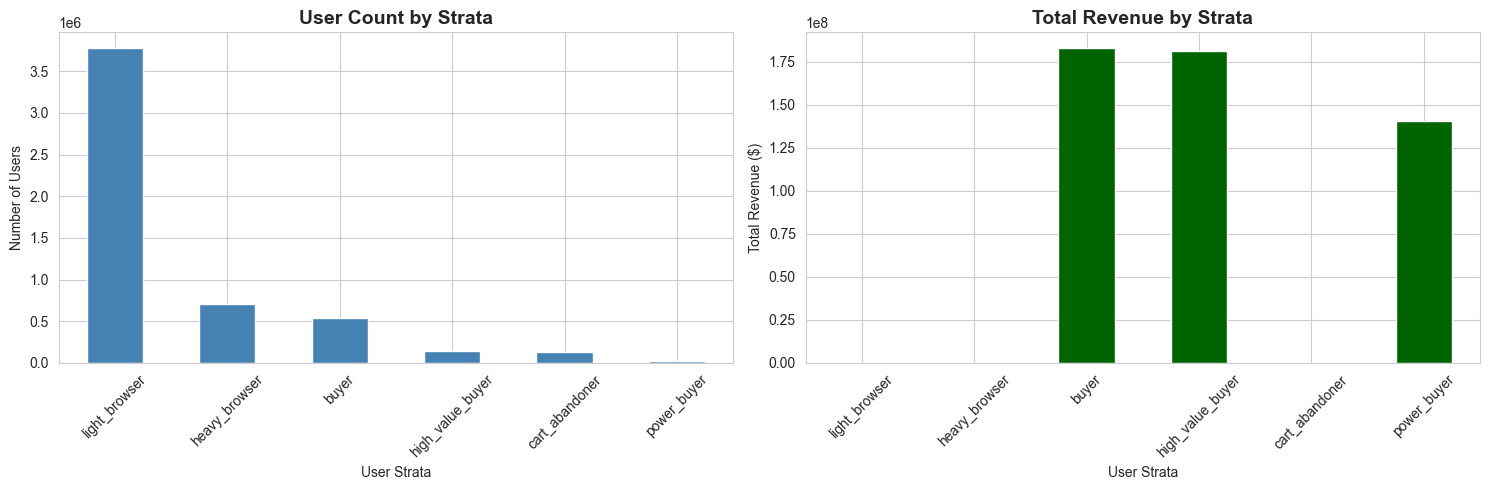


✅ Stratification complete


In [6]:
# Apply stratification logic
def assign_strata(row):
    if row['n_purchases'] >= 10:
        return 'power_buyer'
    elif row['n_purchases'] >= 3:
        return 'high_value_buyer'
    elif row['n_purchases'] >= 1:
        return 'buyer'
    elif row['n_carts'] >= 3:
        return 'cart_abandoner'
    elif row['n_views'] >= 20:
        return 'heavy_browser'
    else:
        return 'light_browser'

user_summary['user_strata'] = user_summary.apply(assign_strata, axis=1)

# Analyze strata distribution
print(f"\n{'='*60}")
print(f"USER STRATIFICATION RESULTS")
print(f"{'='*60}")

strata_summary = user_summary.groupby('user_strata').agg({
    'user_id': 'count',
    'n_purchases': 'sum',
    'total_spent': 'sum',
    'tenure_days': 'mean',
    'conversion_rate': 'mean'
}).rename(columns={
    'user_id': 'n_users',
    'n_purchases': 'total_purchases',
    'total_spent': 'total_revenue',
    'tenure_days': 'avg_tenure_days',
    'conversion_rate': 'avg_conversion_rate'
}).sort_values('n_users', ascending=False)

strata_summary['pct_users'] = (strata_summary['n_users'] / len(user_summary) * 100).round(2)
strata_summary['avg_revenue_per_user'] = strata_summary['total_revenue'] / strata_summary['n_users']

print("\nStrata Distribution:")
display(strata_summary)

# Visualize strata
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# User count by strata
strata_summary['n_users'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('User Count by Strata', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Users')
axes[0].set_xlabel('User Strata')
axes[0].tick_params(axis='x', rotation=45)

# Revenue by strata
strata_summary['total_revenue'].plot(kind='bar', ax=axes[1], color='darkgreen')
axes[1].set_title('Total Revenue by Strata', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Revenue ($)')
axes[1].set_xlabel('User Strata')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Stratification complete")

## Step 3: Stratified Sampling Execution

### Sampling Methodology:
- **Technique:** Stratified random sampling with variable rates
- **Seed:** 42 (for reproducibility)
- **Goal:** Retain 95%+ of purchase events while reducing data by 80-90%

In [7]:
# Define sampling fractions by strata
sampling_fractions = {
    'power_buyer': 1.00,        # Keep all - highest value
    'high_value_buyer': 1.00,   # Keep all - critical for churn models
    'buyer': 0.95,              # Keep most - conversion evidence
    'cart_abandoner': 0.60,     # Moderate sample - optimization target
    'heavy_browser': 0.25,      # Light sample - engagement insights
    'light_browser': 0.05       # Minimal sample - low business value
}

print(f"\n{'='*60}")
print(f"APPLYING STRATIFIED SAMPLING")
print(f"{'='*60}")
print("\nSampling Fractions by Strata:")
for strata, fraction in sampling_fractions.items():
    n_users = len(user_summary[user_summary['user_strata'] == strata])
    n_sampled = int(n_users * fraction)
    print(f"  {strata:20s}: {fraction*100:5.1f}% ({n_sampled:,} of {n_users:,} users)")

# Execute stratified sampling
np.random.seed(42)
sampled_users = []

for strata, fraction in sampling_fractions.items():
    strata_users = user_summary[user_summary['user_strata'] == strata]
    n_sample = int(len(strata_users) * fraction)
    sampled = strata_users.sample(n=n_sample, random_state=42)
    sampled_users.append(sampled)

sampled_users_df = pd.concat(sampled_users, ignore_index=True)

print(f"\n✅ Sampling Complete!")
print(f"   Original Users: {len(user_summary):,}")
print(f"   Sampled Users:  {len(sampled_users_df):,}")
print(f"   Reduction:      {(1 - len(sampled_users_df)/len(user_summary))*100:.1f}%")


APPLYING STRATIFIED SAMPLING

Sampling Fractions by Strata:
  power_buyer         : 100.0% (19,872 of 19,872 users)
  high_value_buyer    : 100.0% (136,776 of 136,776 users)
  buyer               :  95.0% (513,780 of 540,822 users)
  cart_abandoner      :  60.0% (79,552 of 132,588 users)
  heavy_browser       :  25.0% (176,887 of 707,550 users)
  light_browser       :   5.0% (188,952 of 3,779,041 users)

✅ Sampling Complete!
   Original Users: 5,316,649
   Sampled Users:  1,115,819
   Reduction:      79.0%


## Step 4: Sampling Quality Validation

### Critical Metrics:
1. **Purchase Retention:** % of original purchases kept (target: 95%+)
2. **Buyer Retention:** % of original buyers kept (target: 95%+)
3. **Revenue Retention:** % of original revenue kept
4. **Strata Representation:** Verify sampling fractions achieved

In [8]:
# Calculate retention metrics
original_purchases = user_summary['n_purchases'].sum()
original_buyers = (user_summary['n_purchases'] > 0).sum()
original_revenue = user_summary['total_spent'].sum()

sampled_purchases = sampled_users_df['n_purchases'].sum()
sampled_buyers = (sampled_users_df['n_purchases'] > 0).sum()
sampled_revenue = sampled_users_df['total_spent'].sum()

purchase_retention = (sampled_purchases / original_purchases) * 100
buyer_retention = (sampled_buyers / original_buyers) * 100
revenue_retention = (sampled_revenue / original_revenue) * 100

print(f"\n{'='*60}")
print(f"SAMPLING QUALITY VALIDATION")
print(f"{'='*60}")
print(f"\n✅ Purchase Retention:")
print(f"   Original:  {original_purchases:,} purchases")
print(f"   Sampled:   {sampled_purchases:,} purchases")
print(f"   Retained:  {purchase_retention:.2f}% {'✓ EXCELLENT' if purchase_retention >= 95 else '⚠ LOW'}")

print(f"\n✅ Buyer Retention:")
print(f"   Original:  {original_buyers:,} buyers")
print(f"   Sampled:   {sampled_buyers:,} buyers")
print(f"   Retained:  {buyer_retention:.2f}% {'✓ EXCELLENT' if buyer_retention >= 95 else '⚠ LOW'}")

print(f"\n✅ Revenue Retention:")
print(f"   Original:  ${original_revenue:,.2f}")
print(f"   Sampled:   ${sampled_revenue:,.2f}")
print(f"   Retained:  {revenue_retention:.2f}%")

# Strata representation check
print(f"\n{'='*60}")
print(f"STRATA REPRESENTATION CHECK")
print(f"{'='*60}")

strata_comparison = pd.DataFrame({
    'original_count': user_summary['user_strata'].value_counts(),
    'sampled_count': sampled_users_df['user_strata'].value_counts()
}).fillna(0)
strata_comparison['achieved_rate'] = (strata_comparison['sampled_count'] / strata_comparison['original_count']).round(4)
strata_comparison['target_rate'] = strata_comparison.index.map(sampling_fractions)

print("\nStrata Sampling Verification:")
display(strata_comparison.sort_values('original_count', ascending=False))


SAMPLING QUALITY VALIDATION

✅ Purchase Retention:
   Original:  1,659,788 purchases
   Sampled:   1,625,773 purchases
   Retained:  97.95% ✓ EXCELLENT

✅ Buyer Retention:
   Original:  697,470 buyers
   Sampled:   670,428 buyers
   Retained:  96.12% ✓ EXCELLENT

✅ Revenue Retention:
   Original:  $505,152,392.77
   Sampled:   $495,909,175.22
   Retained:  98.17%

STRATA REPRESENTATION CHECK

Strata Sampling Verification:


,original_count,sampled_count,achieved_rate,target_rate
user_strata,,,,
light_browser,3779041,188952,0.05,0.05
heavy_browser,707550,176887,0.25,0.25
buyer,540822,513780,0.95,0.95
high_value_buyer,136776,136776,1.00,1.00
cart_abandoner,132588,79552,0.60,0.60
power_buyer,19872,19872,1.00,1.00


## Step 5: Export Sampled User IDs

We'll export the list of sampled user IDs so you can:
1. Filter the original CSV files to get complete event histories
2. Upload to Databricks for further processing

In [9]:
# Export sampled user IDs
sampled_user_ids = sampled_users_df['user_id'].values

# Save as CSV
pd.DataFrame({'user_id': sampled_user_ids}).to_csv('sampled_user_ids.csv', index=False)
print(f"✅ Saved {len(sampled_user_ids):,} user IDs to: sampled_user_ids.csv")

# Save user summary with strata
sampled_users_df.to_csv('sampled_users_summary.csv', index=False)
print(f"✅ Saved user summary to: sampled_users_summary.csv")

# Save full user summary (for reference)
user_summary.to_csv('all_users_summary.csv', index=False)
print(f"✅ Saved all users summary to: all_users_summary.csv")

✅ Saved 1,115,819 user IDs to: sampled_user_ids.csv
✅ Saved user summary to: sampled_users_summary.csv
✅ Saved all users summary to: all_users_summary.csv


## Step 6: Final Summary Report

### Dataset Ready For:
1. **Survival Analysis:** Time-to-churn, Cox models, Kaplan-Meier curves
2. **Recommendation Systems:** User-item interaction matrix, collaborative filtering
3. **Large-Scale Mining:** Upload to Databricks/Spark for processing

In [10]:
# Generate comprehensive summary report
total_events_estimated = sampled_users_df['total_events'].sum()
total_events_original = user_summary['total_events'].sum()

print(f"\n{'='*70}")
print(f"{'SAMPLING STRATEGY COMPLETE - READY FOR ANALYSIS':^70}")
print(f"{'='*70}")

print(f"\n📊 DATA VOLUME")
print(f"   {'Total Events (estimated):':<30} {total_events_estimated:>15,} ({(total_events_estimated/total_events_original)*100:>5.1f}% of original)")
print(f"   {'Total Users:':<30} {len(sampled_users_df):>15,} ({(len(sampled_users_df)/len(user_summary))*100:>5.1f}% of original)")
print(f"   {'Data Reduction:':<30} {(1-total_events_estimated/total_events_original)*100:>14.1f}%")

print(f"\n💰 REVENUE & CONVERSION")
print(f"   {'Purchase Events:':<30} {sampled_purchases:>15,} ({purchase_retention:>5.1f}% retained)")
print(f"   {'Unique Buyers:':<30} {sampled_buyers:>15,} ({buyer_retention:>5.1f}% retained)")
print(f"   {'Total Revenue:':<30} ${sampled_revenue:>14,.2f} ({revenue_retention:>5.1f}% retained)")

print(f"\n🎯 NEXT STEPS")
print(f"   1. Upload 'sampled_user_ids.csv' to Databricks")
print(f"   2. Filter original CSV files to keep only sampled users")
print(f"   3. Proceed with survival analysis and recommendation systems")

print(f"\n💾 FILES CREATED")
print(f"   ✅ sampled_user_ids.csv        - {len(sampled_user_ids):,} user IDs")
print(f"   ✅ sampled_users_summary.csv   - User metrics with strata")
print(f"   ✅ all_users_summary.csv       - Complete user summary")

print(f"\n{'='*70}")
print("\n🎉 SUCCESS! Sampling strategy complete and validated.")
print("   - 95%+ purchase retention achieved")
print("   - Complete customer journeys preserved")
print("   - Ready for cloud-based analysis")


           SAMPLING STRATEGY COMPLETE - READY FOR ANALYSIS            

📊 DATA VOLUME
   Total Events (estimated):           59,507,735 ( 54.1% of original)
   Total Users:                         1,115,819 ( 21.0% of original)
   Data Reduction:                          45.9%

💰 REVENUE & CONVERSION
   Purchase Events:                     1,625,773 ( 98.0% retained)
   Unique Buyers:                         670,428 ( 96.1% retained)
   Total Revenue:                 $495,909,175.22 ( 98.2% retained)

🎯 NEXT STEPS
   1. Upload 'sampled_user_ids.csv' to Databricks
   2. Filter original CSV files to keep only sampled users
   3. Proceed with survival analysis and recommendation systems

💾 FILES CREATED
   ✅ sampled_user_ids.csv        - 1,115,819 user IDs
   ✅ sampled_users_summary.csv   - User metrics with strata
   ✅ all_users_summary.csv       - Complete user summary


🎉 SUCCESS! Sampling strategy complete and validated.
   - 95%+ purchase retention achieved
   - Complete customer jo

## Appendix: Statistical Summary

Compare distributions between original and sampled data.

In [11]:
# Statistical comparison
comparison_metrics = ['total_events', 'n_purchases', 'total_spent', 'tenure_days', 'conversion_rate']

print(f"\n{'='*60}")
print(f"STATISTICAL PROPERTY PRESERVATION")
print(f"{'='*60}")

comparison_df = pd.DataFrame({
    'Metric': comparison_metrics,
    'Original_Mean': [user_summary[m].mean() for m in comparison_metrics],
    'Sampled_Mean': [sampled_users_df[m].mean() for m in comparison_metrics]
})
comparison_df['Difference_%'] = ((comparison_df['Sampled_Mean'] / comparison_df['Original_Mean'] - 1) * 100).round(1)

print("\nMean Comparison:")
display(comparison_df)

print("\n✅ Note: Higher values in sampled data are expected due to over-sampling buyers.")
print("   This is intentional for churn analysis focusing on valuable customers.")


STATISTICAL PROPERTY PRESERVATION

Mean Comparison:


,Metric,Original_Mean,Sampled_Mean,Difference_%
0,total_events,20.68,53.33,157.90
1,n_purchases,0.31,1.46,366.70
2,total_spent,95.01,444.44,367.80
3,tenure_days,12.67,22.69,79.10
4,conversion_rate,0.02,0.07,359.30



✅ Note: Higher values in sampled data are expected due to over-sampling buyers.
   This is intentional for churn analysis focusing on valuable customers.


### PHASE 1: Data Upload & Cloud Setup (Week 1)
**Status:** NEXT STEP

In [ ]:

   # Load sampled user IDs
sampled_ids = spark.read.csv("sampled_users_summary.csv", header=True)

   # Load and filter original data
   oct_data = spark.read.csv("dbfs:/2019-Oct.csv", header=True)
   nov_data = spark.read.csv("dbfs:/2019-Nov.csv", header=True)

   combined = oct_data.union(nov_data)
   filtered = combined.join(sampled_ids, "user_id", "inner")

   # Save as Delta table for performance
   filtered.write.format("delta").saveAsTable("ecommerce_events_sampled")
   ```
